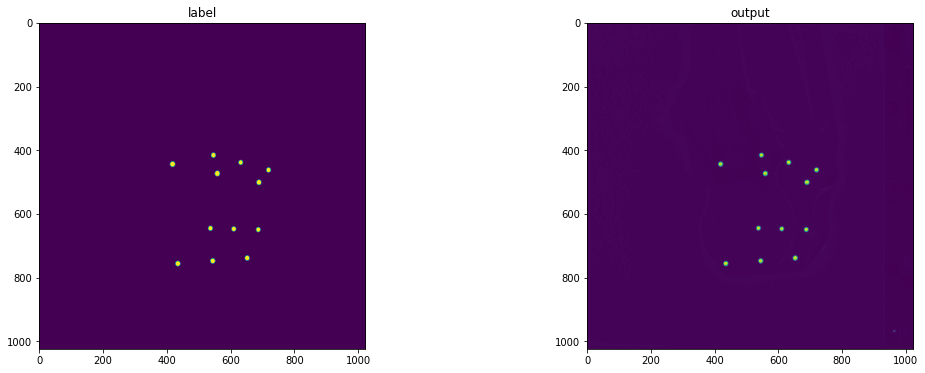

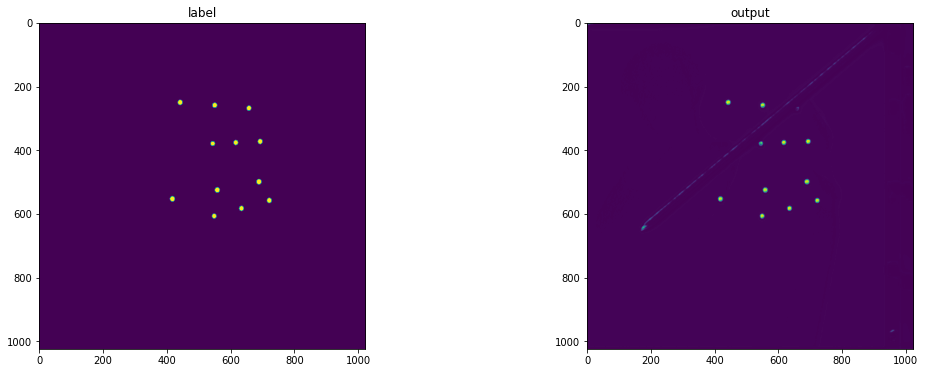

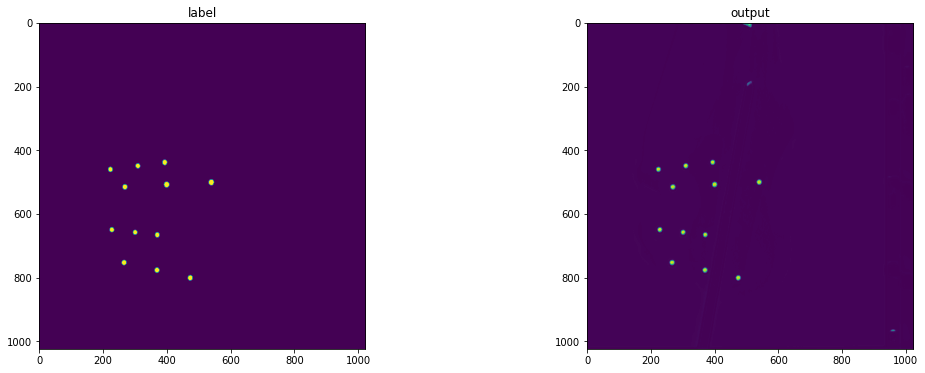

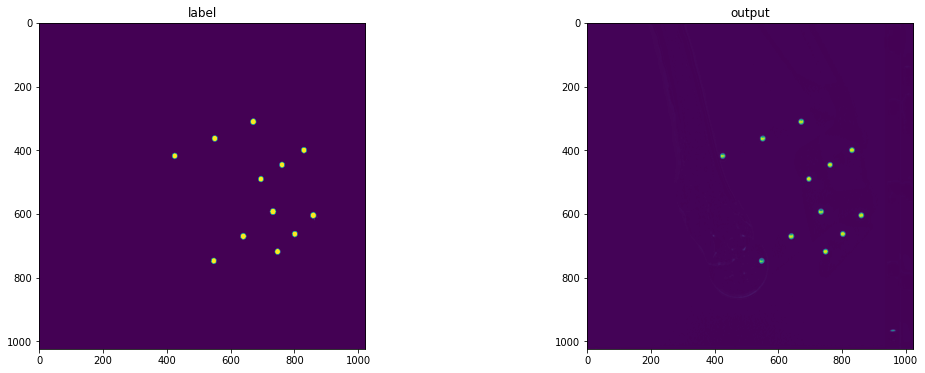

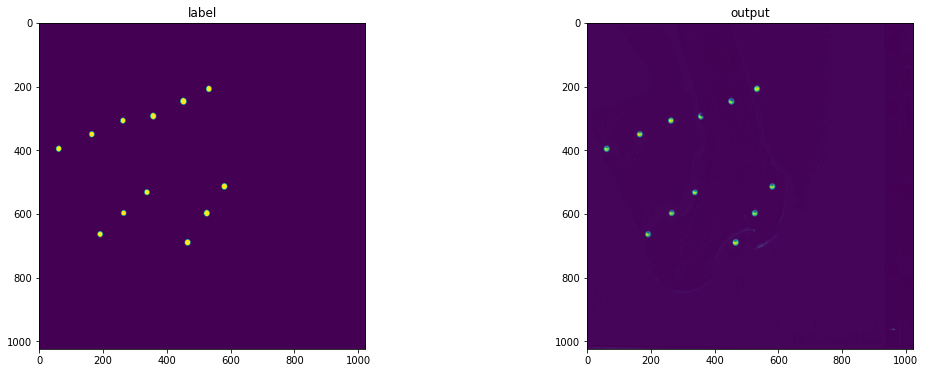

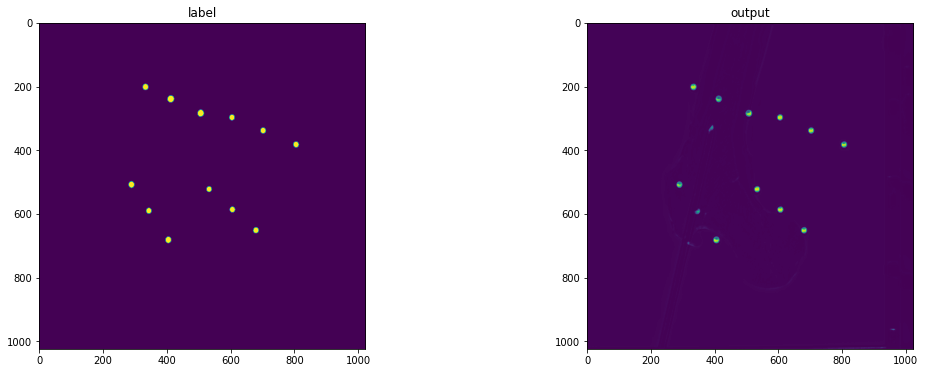

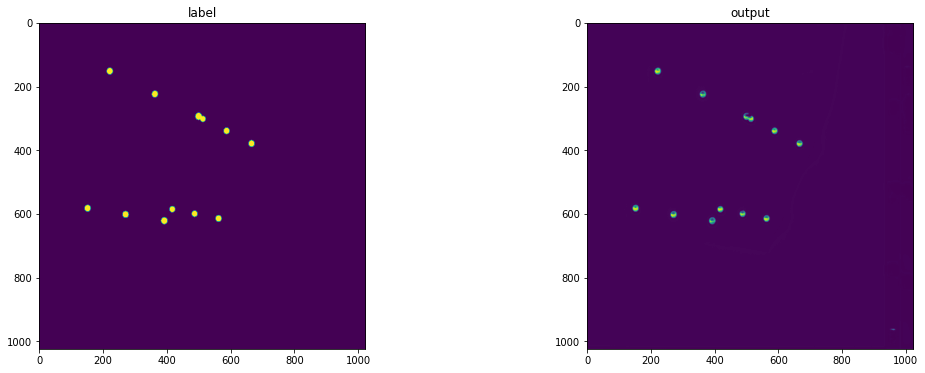

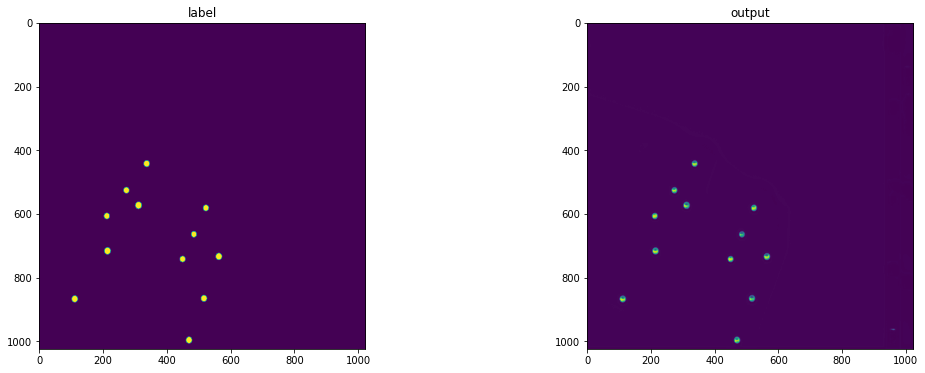

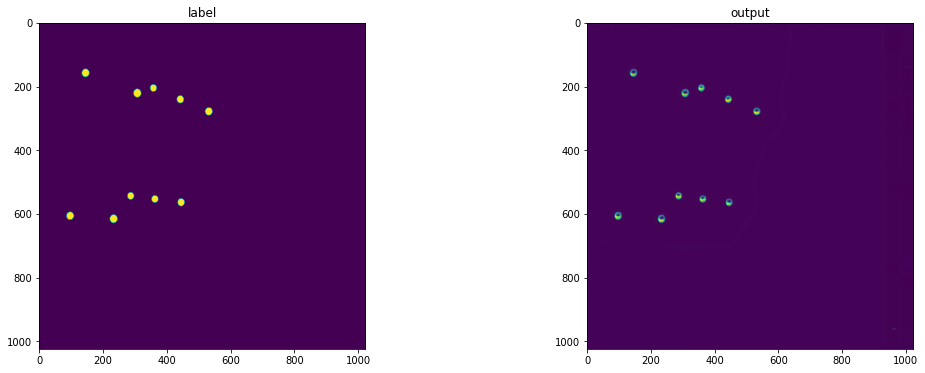

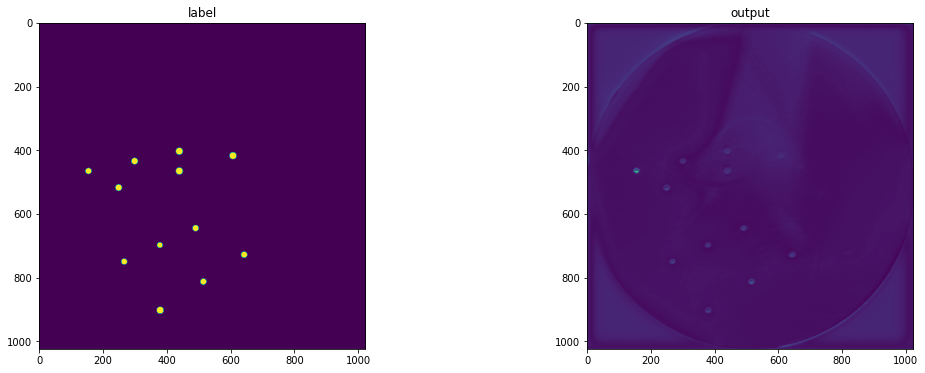

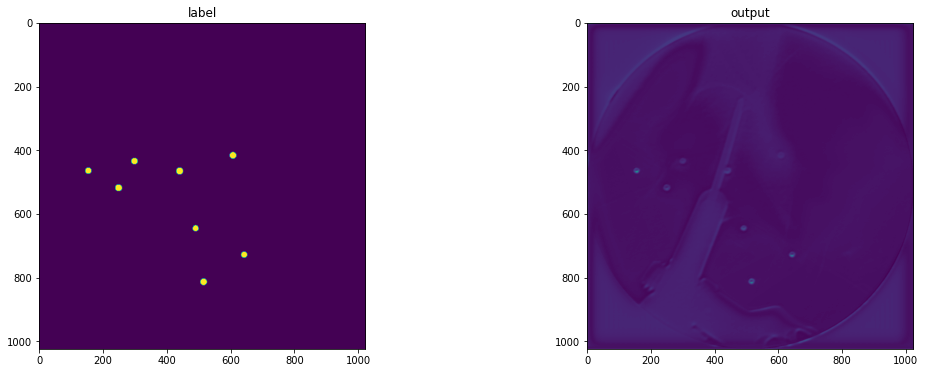

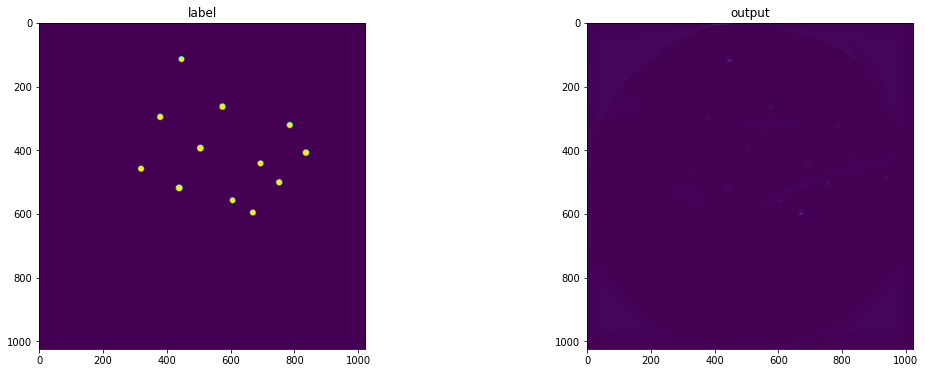

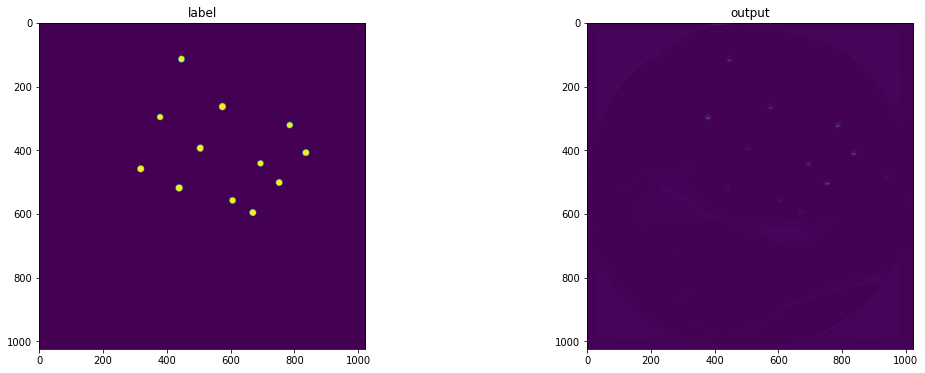

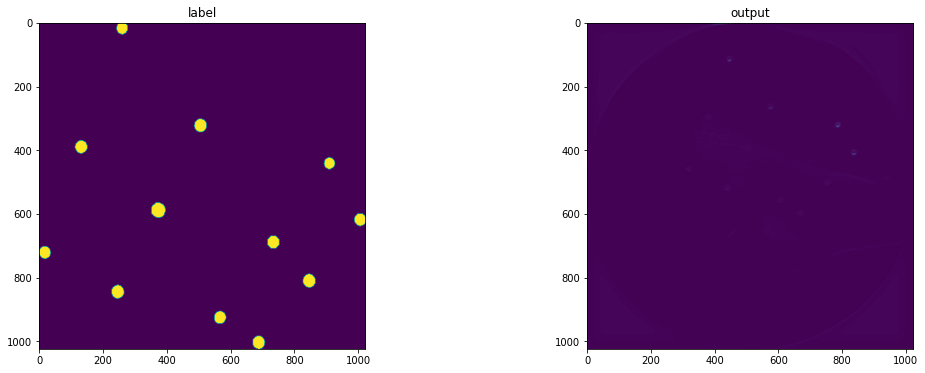

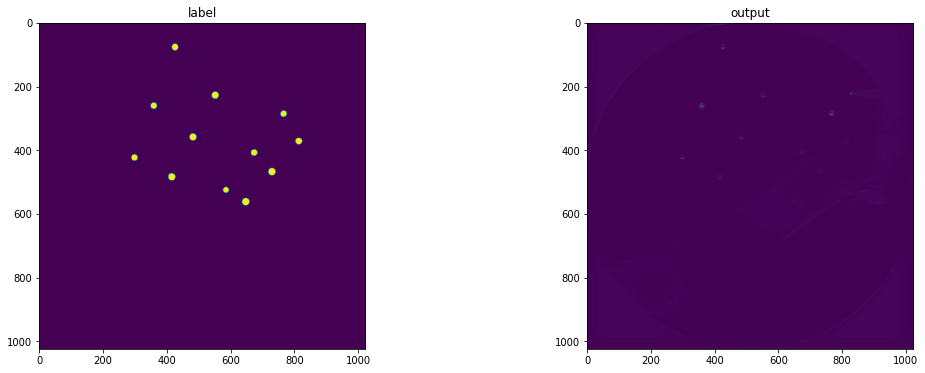

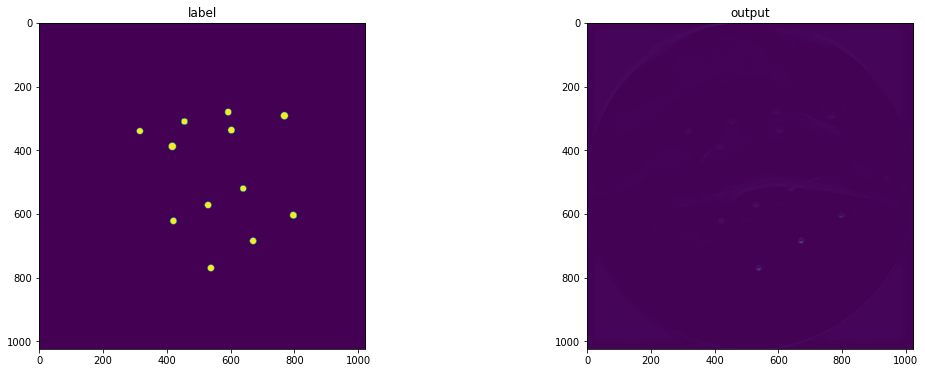

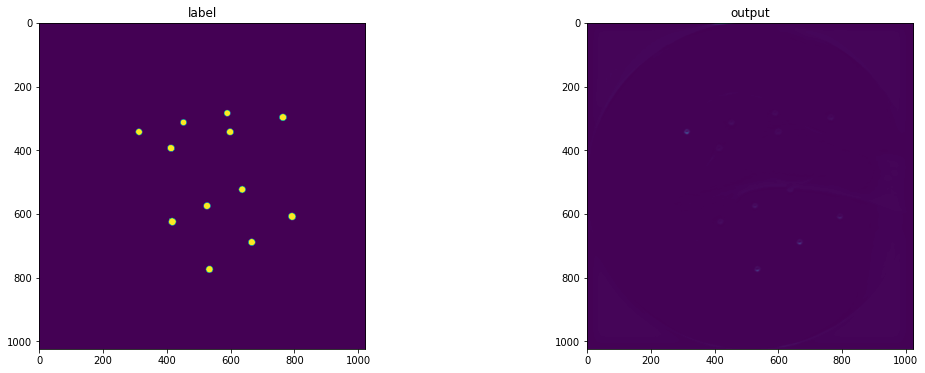

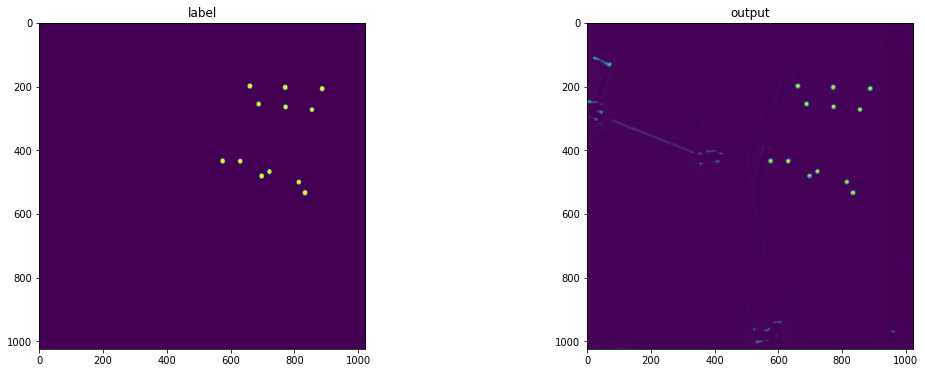

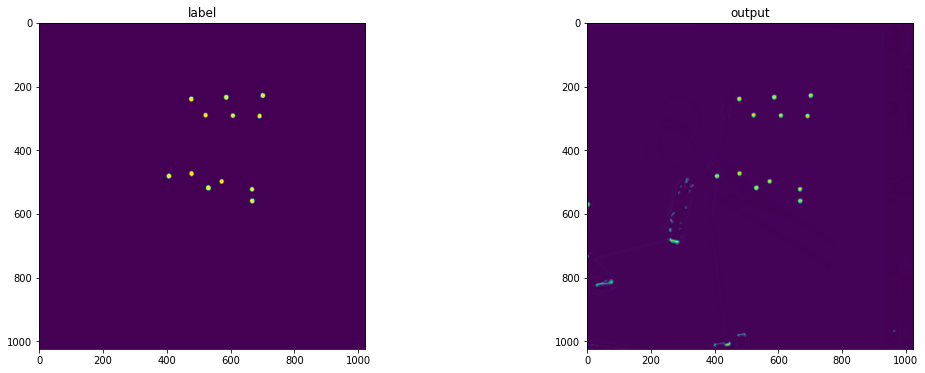

In [13]:
from numpy.core.fromnumeric import size
import torch
import argparse
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.transforms import transforms
from unet import Unet
from dataset import LiverDataset


# 是否使用cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((1024,1024)),
    transforms.Normalize([0.5], [0.5])
])

# mask只需要转换为tensor
y_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((1024,1024)),
])

def train_model(model, criterion, optimizer, dataload, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dt_size = len(dataload.dataset)
        epoch_loss = 0
        step = 0
        for x, y in dataload:
            step += 1
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // dataload.batch_size + 1, loss.item()))
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss/step))
    torch.save(model.state_dict(), 'weights_%d.pth' % epoch)
    return model

#训练模型
def train():
    model = Unet(1, 1).to(device)
    batch_size = 2
    # batch_size = args.batch_size
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(),1e-3)
    liver_dataset = LiverDataset("/home/xindong/project/Unet-pytorch/data/imagesTr",transform=x_transforms,target_transform=y_transforms)
    dataloaders = DataLoader(liver_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    train_model(model, criterion, optimizer, dataloaders)

#显示模型的输出结果
def test():
    model = Unet(1, 1)
    model.load_state_dict(torch.load("weights_19.pth",map_location='cpu'))
    liver_dataset = LiverDataset("/home/xindong/project/Unet-pytorch/data/imagesTs", transform=x_transforms,target_transform=y_transforms)
    dataloaders = DataLoader(liver_dataset, batch_size=1)
    model.eval()
    import matplotlib.pyplot as plt
    plt.ion()
    with torch.no_grad():
        for x, mask in dataloaders:
            plt.figure("image", (18, 6))
            plt.subplot(1, 2, 1)
            plt.title("label")
            plt.imshow(mask[0,0,...])
            y=model(x).sigmoid()
            img_y=torch.squeeze(y).numpy()
            print(f"output size;{img_y.shape}")
            plt.subplot(1, 2, 2)
            plt.title("output")
            plt.imshow(img_y)
            plt.pause(0.01)
        plt.show()


if __name__ == '__main__':
    #参数解析
    # parse=argparse.ArgumentParser()
    # parse.add_argument("--action", type=str, default="train",help="train or test")
    # parse.add_argument("--batch_size", type=int, default=2)
    # parse.add_argument("--ckpt", type=str, help="the path of model weight file")
    # args = parse.parse_args()

    # if args.action=="train":
    #     train(args)
    # elif args.action=="test":
    #     test(args)
    #train()
    test()
